In [107]:
import numpy as np # fast math + arrays
import pandas as pd # read CSVs, data tables
import scipy.stats as st # probability models + .fit()
import matplotlib.pyplot as plt # plotting
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.special as sp
# ECDF: nonparametric cumulative curve
# --- OPTIONAL PLOT STYLE (makes plots cleaner; OK to skip) -----------------
plt.rcParams.update({
"axes.spines.top": False, # cleaner axes
"axes.spines.right": False,
"axes.grid": True, # light grid helps read values
"grid.alpha": 0.25,
})

In [108]:
def plot_ecdf(data, ax=None, **kw):
    """
    Make an ECDF step plot.
    WHY: shows all data points; no bins; great for comparing to model CDFs.
    """
    ec = ECDF(data) # compute ECDF object (x,y steps)
    ax = ax or plt.gca() # use passed axes OR current axes
    ax.step(ec.x, ec.y, where="post", **kw)
    ax.set_xlabel("Wait (min)")
    ax.set_ylabel("F_hat(x)") # F-hat = empirical CDF
    return ax

def aic(logL, k):
    """
    Compute Akaike Information Criterion.
    AIC = 2*k - 2*logL
    logL = maximized log-likelihood; k = # free parameters in model.
    Lower AIC -> better tradeoff fit vs complexity (same dataset only!).
    """
    return 2*k - 2*logL

def mean_from_params(dist_name, params):
    """
    Convert SciPy .fit() parameters -> model mean (in minutes).
    SciPy returns (shape[s], loc, scale) in this order for most continuous dists.
    NOTE: ’loc’ shifts the distribution; ’scale’ stretches it.
    """
    if dist_name == "gamma":
        a, loc, scale = params # a = shape (k)
        return loc + a*scale # Gamma mean = loc + k*theta
    elif dist_name == "weibull_min":
        c, loc, scale = params # c = shape
    # Weibull mean uses the gamma function:
        return loc + scale*sp.gamma(1 + 1/c)
    elif dist_name == "lognorm":
        s, loc, scale = params # s = sigma (log-scale SD); scale = exp(mu)
    # mean = loc + scale * exp( sigma^2 / 2 )
        return loc + scale * np.exp(s**2 / 2)
    else:
        return np.nan # unknown model

In [109]:
df = pd.read_csv('data/census_population_2020.csv')

df = df.drop(0)

unnamed_cols = df.columns[df.columns.str.contains('Unnamed', case=False)]

df.drop(columns=unnamed_cols, inplace=True)

df.rename(columns={'P1_001N': 'population'}, inplace=True)

df['population'] = df['population'].astype(int)

df


,GEO_ID,NAME,population
1,860Z200US00601,ZCTA5 00601,17242
2,860Z200US00602,ZCTA5 00602,37548
3,860Z200US00603,ZCTA5 00603,49804
4,860Z200US00606,ZCTA5 00606,5009
5,860Z200US00610,ZCTA5 00610,25731
...,...,...,...
33770,860Z200US99923,ZCTA5 99923,66
33771,860Z200US99925,ZCTA5 99925,784
33772,860Z200US99926,ZCTA5 99926,1562
33773,860Z200US99927,ZCTA5 99927,49


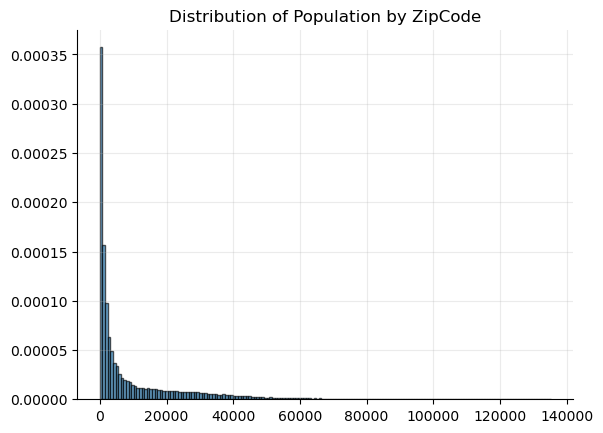

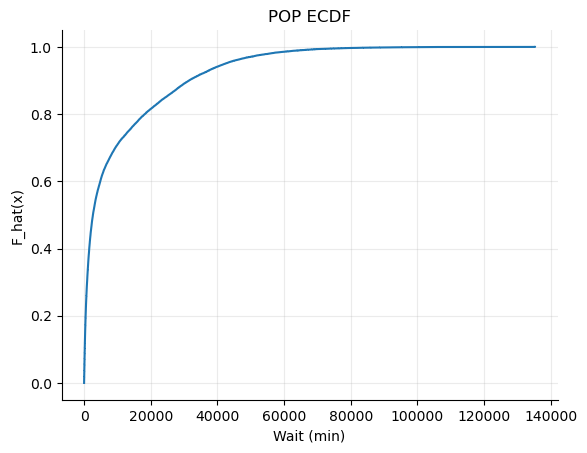

In [110]:
pop = df['population'].to_numpy()

plt.hist(df['population'], bins="auto", density=True, alpha=.65, edgecolor="k")
plt.title('Distribution of Population by ZipCode')
plt.show()

plot_ecdf(pop, color="C0"); plt.title("POP ECDF")
plt.show()


In [111]:
candidates = {
    "gamma": st.gamma,
    "weibull_min": st.weibull_min,
    'lognorm':st.lognorm # swap/add "lognorm": st.lognorm if you like
}
print("Candidate models:", list(candidates))

Candidate models: ['gamma', 'weibull_min', 'lognorm']


In [112]:
def fit_models(data, models):
    """
    Fit each SciPy distribution in ‘models‘ to 1-D numpy array ‘data‘.
    Returns a DataFrame (rows = models, columns = params/logL/k/AIC) sorted by AIC.
    """
    out = {}
    for name, dist in models.items():
        params = dist.fit(data) # MLE: find params that max log-likelihood
        logL = dist.logpdf(data, *params).sum() # total log-likelihood at those params
        k = len(params) # number of fitted parameters
        out[name] = dict(params=params, logL=logL, k=k, AIC=aic(logL,k))
    return pd.DataFrame(out).T.sort_values("AIC") # lower AIC = better
# --- FIT PRE & POST --------------------------------------------------------
fit_pop = fit_models(pop, candidates)

print("POP fits:"); display(pop)

best_model_pop = fit_pop['AIC'].idxmin()
pop_min_row = fit_pop.loc[best_model_pop]

print(f'POP Best Model: {best_model_pop}: (AIC = {pop_min_row['AIC']})')

print("POP fits:"); display(fit_pop)

POP fits:


/opt/anaconda3/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:6921: RuntimeWarning: divide by zero encountered in log
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


array([17242, 37548, 49804, ...,  1562,    49,  2079])

POP Best Model: gamma: (AIC = 666740.9899817001)
POP fits:


,params,logL,k,AIC
gamma,"(0.5727932482915363, -2.942402647908673e-25, 1...",-333367.494991,3,666740.989982
lognorm,"(1.9186547970653773, -8.335807624850558, 2596....",-335465.026645,3,670936.053289
weibull_min,"(0.602919073705614, -1.1410077570751758e-24, 1...",-335826.598957,3,671659.197915


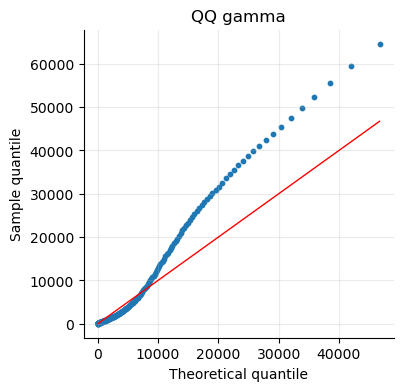

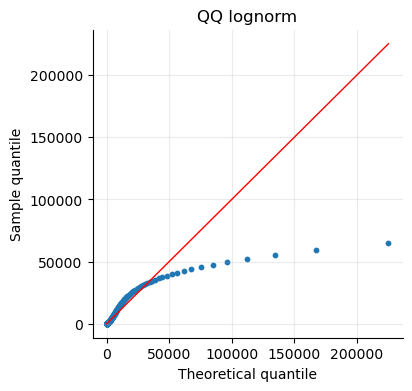

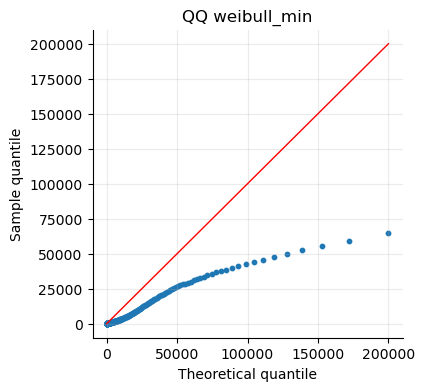

In [113]:
def qq_compare(data, fit_tbl, models, probs=np.linspace(.01,.99,200)):
    """
    Make QQ plots for each fitted model in fit_tbl.
    'probs' are the quantile levels (0-1) we compare.
    """
    qs = np.quantile(data, probs) # sample quantiles from data
    for name in fit_tbl.index: # models in AIC order
        dist = models[name]
        params = fit_tbl.loc[name,"params"]
        qt = dist.ppf(probs, *params) # theoretical quantiles from model
        plt.figure(figsize=(4,4))
        plt.scatter(qt, qs, s=10)
        plt.plot(qt, qt, 'r', lw=1) # 45 reference line
        plt.title(f"QQ {name}")
        plt.xlabel("Theoretical quantile")
        plt.ylabel("Sample quantile")
        plt.show()

# --- MAKE QQ PLOTS ---------------------------------------------------------
qq_compare(pop, fit_pop, candidates)

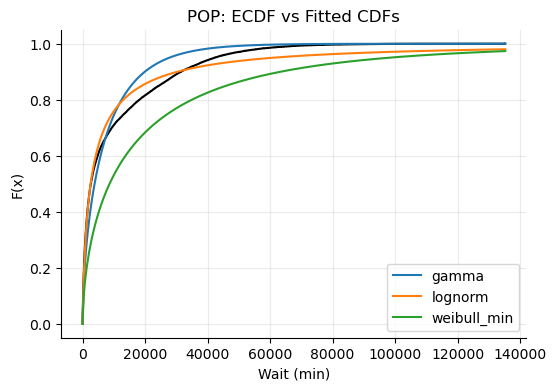

In [114]:
def cdf_overlay(data, fit_tbl, models, title):
    """
    ECDF (black steps) + each fitted model’s CDF (smooth lines).
    """
    plt.figure(figsize=(6,4))
    plot_ecdf(data, color="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.cdf(xx, *pars), label=name)
        plt.legend(); plt.title(title)
        plt.xlabel("Wait (min)"); plt.ylabel("F(x)")
# --- MAKE CDF OVERLAYS -----------------------------------------------------
cdf_overlay(pop, fit_pop, candidates, title="POP: ECDF vs Fitted CDFs")

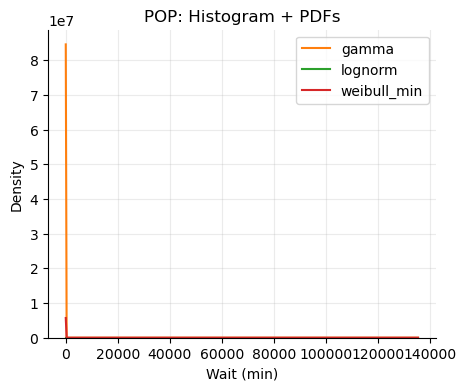

In [115]:
def pdf_overlay(data, fit_tbl, models, title):
    """
    Histogram (density=True) + PDFs from each fitted model.
    """
    plt.figure(figsize=(5,4))
    plt.hist(data, bins="auto", density=True, alpha=.35, edgecolor="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.pdf(xx, *pars), label=name)
        plt.legend(); plt.title(title)
        plt.xlabel("Wait (min)"); plt.ylabel("Density")
# --- MAKE PDF OVERLAYS -----------------------------------------------------
pdf_overlay(pop, fit_pop, candidates, "POP: Histogram + PDFs")

In [116]:
# --- PICK BEST MODELS BY AIC -----------------------
best_pop = fit_pop.index[0]
# --- GET MEANS FROM FITTED PARAMS ------------------------------------------
mu_pop = mean_from_params(best_pop, fit_pop.loc[best_pop,"params"])
# --- PRACTICAL CHANGE -------------------------------------------------------
print(f"Best Pop model: {best_pop} mean {mu_pop:.2f} population")

Best Pop model: gamma mean 7582.87 population


### Analysis

For the distribution of population by zipcode, it is clearly very very very skewed to the right.

This is because there are more rural zip codes than there are urban zip codes, yet these urban zip codes will have very high population.

The largest population is way out as an outlier.

That way, none of the models as candidates really fit well for prediction. Gamma kind of fits at the end but the front for all three is quite questionable.

The mean population prediction by gamma is 7582.87.